<a href="https://colab.research.google.com/github/alexandrehsd/nlp-and-transformers/blob/main/02_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification

In this chapter, we are going to work on a task of text classification with transformers. To accomplish that, we are going to use three of the core libraries from the Hugging Face ecosystem: Datasets, Tokenizers, and Transformers.

## The Dataset

The dataset is comprised of tweets, and the label of the dataset can assume six classes about the sentiment expressed on the tweet:
1. Anger
2. Disgust
3. Fear
4. Joy
5. Sadness
6. Surprise

In [1]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

/var/folders/n0/fjbb__hs3pg2sbx4w8k8h3180000gq/T/ipykernel_16439/89111038.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 154699 datasets currently available on the Hub
The first 10 are: ['amirveyseh/acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]

In [5]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [6]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

### From Datasets to DataFrames

In [7]:
import pandas as pd

In [8]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [10]:
df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


#### Looking at the Class Distribution

In [11]:
import matplotlib.pyplot as plt

The problem with word tokenization is that there may be many variants of a single word. Besides, depending on the tokenization method, we can get some erroneos tokens such as 'NLP.' in the example above.

We can use stemming or lemmatization to standardize tokens, but we lose information in the process. Consider a corpus of words containing 1M words. If we wish to use a neural network to reduce these representations to a 1,000 dimensional vector we would need 1M x 1K = 1B weights. That's too much to process.

An alternative approach would be to get the top 100,000 words and put the rest under a UNK token. In that way, we would still be losing information but it would be less harmful to the training process.

Using subword tokenization, we get a compromise between character and word tokenization where we can preserve all the input information and some of the input structure.

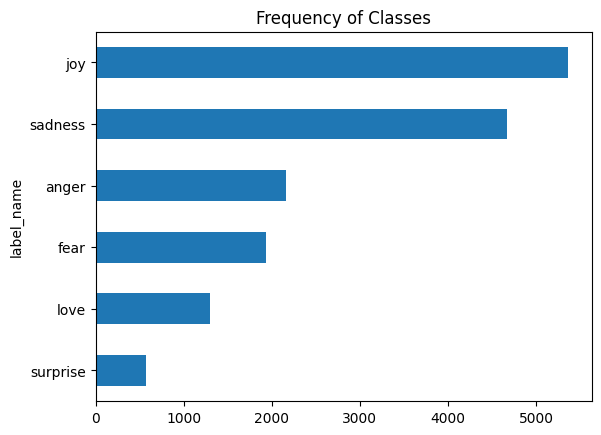

In [12]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

#### How Long Are Our Tweets?

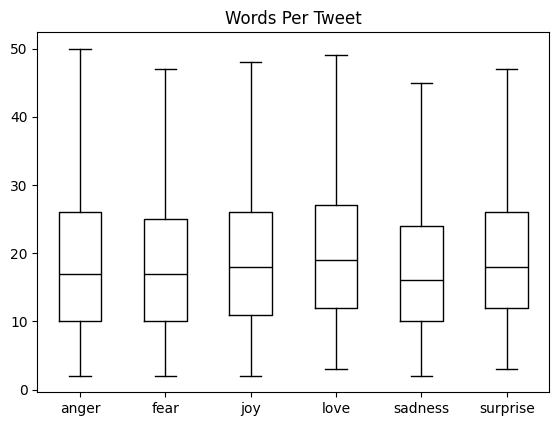

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

### From Text to Tokens

In [14]:
emotions.reset_format()

The optimal splitting of words into subunits is usually learned from the corpus. First, let's consider two extreme cases: character and word tokenization.

#### Character Tokenization

In [15]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
# tokenized_text

In [16]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}

In [17]:
input_ids = [token2idx[token] for token in tokenized_text]

In [18]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [19]:
input_ids

tensor([ 5, 14, 12,  8, 13, 11, 19, 11, 13, 10,  0, 17,  8, 18, 17,  0, 11, 16,
         0,  6,  0,  7, 14, 15,  8,  0, 17,  6, 16, 12,  0, 14,  9,  0,  3,  2,
         4,  1])

#### Word Tokenization

In [20]:
tokenized_text = text.split()
token2idx = {word: idx for idx, word in enumerate(sorted(set(tokenized_text)))}
input_ids = [token2idx[token] for token in tokenized_text]

input_ids = torch.tensor(input_ids)
input_ids

tensor([1, 7, 4, 2, 3, 6, 5, 0])

#### Subword Tokenization

The main distinguishing feature of subword tokenization is that it is learned from the pre-training corpus using a mix of statistical rules and algoritms.
To perform subword tokenization, we'll be using WordPiece, which is used by the BERT and DistilBERT tokenizers.

In [21]:
# load the DistilBERT tokenizer with AutoTokenizer
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

The `Autokenizer` belongs to a larger set of "auto" classes that allows us to pull model's configuration, pretrained weights, or vocabulary from other models. But we could've imported directly the distilbert tokenizer:

```python

from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
```

In [22]:
encoded_text = tokenizer(text)
encoded_text

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [23]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In this specific tokenizer, the '[CLS]' and '[SEP]' tokens indicate the begginning and the end of the sentence. The occurence of '##' indicate the they should be merged back to the original string when tokens are converted back to string.

In [24]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [25]:
tokenizer.vocab_size

30522

In [26]:
tokenizer.model_max_length

512

In [27]:
# fields that the model expects in its forward pass
tokenizer.model_input_names

['input_ids', 'attention_mask']

#### Tokenizing the Whole Dataset

In [28]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [29]:
emotions["train"][:2]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'],
 'label': [0, 0]}

In [30]:
tokenize(emotions["train"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [31]:
# use the map method to tokenize the whole dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

In [32]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

## Training a Text Classifier

Models like DistilBERT are pretrained to predict masked words in a sequence of text. Thus, to perform text classification, we must change a few things on its architecture.

We have two options to train such a model on our Twitter dataset:

1. Feature Extraction: We use the hidden states as features and just train a classifier on them, without modifying the pretained model.
2. Fine-Tuning: We train thw whole model end-to-end, which also updates the parameters of the pretrained model.

### Transformers as Features Extractors

In [33]:
# Load the DistilBERT to load the weights of the pretrained DistilBERT model
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(model_ckpt).to(device)

The AutoModel class converts the token encodings to embeddings, and then feeds them through the encoder stack to return the hidden states. Let's take a look at how we can extract these states from our corpus.

#### Extracting the last hidden states

In [34]:
# getting the last hidden states for a single string
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")

print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [35]:
inputs.items()

dict_items([('input_ids', tensor([[ 101, 2023, 2003, 1037, 3231,  102]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])

In [36]:
# pass the input through the model
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():  # torch.no_grad disables the automatic calculation of the gradient
  outputs = model(**inputs)

outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)

In [37]:
outputs.last_hidden_state

tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]])

In [38]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

The hidden state tensor has shape [batch_size, n_tokens, hidden_dim]. For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token as the input feature. Since this token appears at the start of each sequence, we can extract it by simply indexing into outputs.last_hidden_state as follows:

In [39]:
# outputs.last_hidden_state[:, 0]

In [40]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

In [41]:
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  # Return the vector for [CLS] token
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}  # the map method requires numpy arrays as output

In [42]:
type(emotions_encoded)

datasets.dataset_dict.DatasetDict

In [43]:
# the model expects tensors as inputs
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [44]:
# extract hidden states accros all splits in one go
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

#### Creating a feature matrix

We need to create a feature matrix to train a classifier.

In [45]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### Visualizing the training set

In [46]:
# import umap
# from sklearn.preprocessing import MinMaxScaler # Scale features to [0,1] range

# X_scaled = MinMaxScaler().fit_transform(X_train)

# # Initialize and fit UMAP
# mapper = umap.umap_(n_components=2, metric="cosine").fit(X_scaled)

# # Create a DataFrame of 2D embeddings
# df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
# df_emb["label"] = y_train
# df_emb.head()

In [47]:
# fig, axes = plt.subplots(2, 3, figsize=(7,5))
# axes = axes.flatten()
# cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

# for i, (label, cmap) in enumerate(zip(labels, cmaps)):
#   df_emb_sub = df_emb.query(f"label == {i}")
#   axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
#   axes[i].set_title(label)
#   axes[i].set_xticks([]), axes[i].set_yticks([])

# plt.tight_layout()
# plt.show()

#### Training a simple classifier

In [48]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


0.634

In [49]:
from sklearn.dummy import DummyClassifier

# Training a baseline classifier that predicts the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

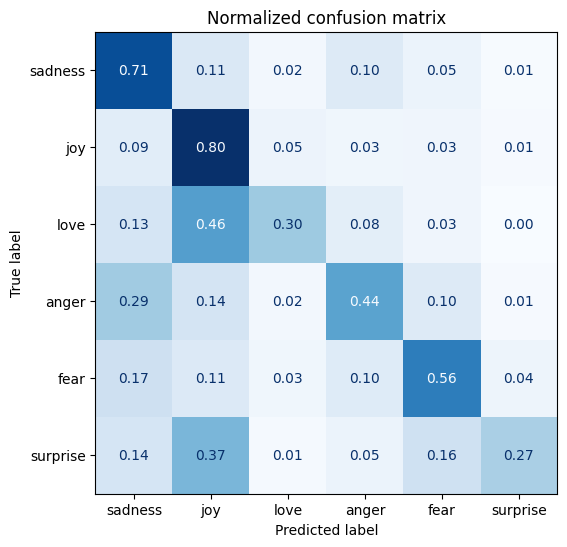

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Fine-Tuning Transformers

In this section, we'll train a classifier using the Trainer API from transformers.

In [51]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Defining the performance metrics

In [52]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "f1": f1}

#### Training the model

In [66]:
# login in the huggingface hug
# from huggingface_hub import notebook_login

# notebook_login()

# or use 'huggingface-cli login' in the terminal

In [67]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [70]:
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"], eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

In [71]:
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

TrainOutput(global_step=500, training_loss=0.1882891082763672, metrics={'train_runtime': 860.39, 'train_samples_per_second': 37.192, 'train_steps_per_second': 0.581, 'total_flos': 720342861696000.0, 'train_loss': 0.1882891082763672, 'epoch': 2.0})

In [72]:
preds_output = trainer.predict(emotions_encoded["validation"] )

  0%|          | 0/32 [00:00<?, ?it/s]

In [73]:
preds_output.metrics

{'test_loss': 0.1540987491607666,
 'test_accuracy': 0.9335,
 'test_f1': 0.9338075009603245,
 'test_runtime': 8.2773,
 'test_samples_per_second': 241.624,
 'test_steps_per_second': 3.866}

In [76]:
y_preds = np.argmax(preds_output.predictions, axis=1)

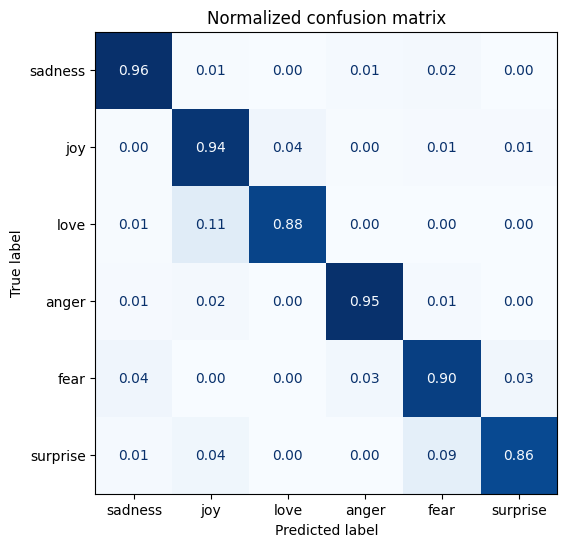

In [77]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### Error Analysis

Before calling it a day, it might be interesting to analyse the model error. Let's get the model loss for all samples and then print the biggest losses and the lowest. 

To do it, we must perform a forward-pass:

In [80]:
from torch.nn.functional import cross_entropy


def forward_pass_with_label(batch):
    # place all input tensors on the same device as the model
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
        
    # place outputs on CPU for compatibility with other dataset columns
    return {
        "loss": loss.cpu().numpy(),
        "predicted_label": pred_label.cpu().numpy()
    }


# Move the model to the device
model.to(device)

# convert our dataset back to PyTorch tensors 
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16
)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [81]:
emotions_encoded.set_format("pandas")

cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [82]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,6.805609
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.794338
1509,i guess this is a memoir so it feels like that...,joy,fear,5.499784
318,i felt ashamed of these feelings and was scare...,fear,sadness,5.446388
1963,i called myself pro life and voted for perry w...,joy,sadness,5.409131
1950,i as representative of everything thats wrong ...,surprise,sadness,5.271557
1111,im lazy my characters fall into categories of ...,joy,fear,5.106523
1840,id let you kill it now but as a matter of fact...,joy,fear,4.636893
177,im sure much of the advantage is psychological...,sadness,joy,4.412953
1124,someone acting stupid in public,anger,sadness,4.206063


In [83]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.003623
1326,i am feeling neglectful i feel like i should h...,sadness,sadness,0.003642
1965,i started feeling pathetic and ashamed,sadness,sadness,0.003651
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.003691
1929,i start feeling dumb,sadness,sadness,0.003693
69,i have no extra money im worried all of the ti...,sadness,sadness,0.003708
34,i feel that i m so pathetic and downright dumb...,sadness,sadness,0.003709
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.003715
856,i feel is more energetic in urban singapore th...,joy,joy,0.003721
1810,i feel like i m going to become sleep deprived...,sadness,sadness,0.003726


#### Saving and sharing the model

In [84]:
trainer.push_to_hub(commit_message="Hello HuggingFace")

events.out.tfevents.1717107300.BRSPPM-C02GL2FZMD6M.local.16439.1:   0%|          | 0.00/6.60k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/alexandrehsd/distilbert-base-uncased-finetuned-emotion/commit/2c99a0dece6cc546c2dd78654d8f5df029038022', commit_message='Hello HuggingFace', commit_description='', oid='2c99a0dece6cc546c2dd78654d8f5df029038022', pr_url=None, pr_revision=None, pr_num=None)

In [85]:
# now we can use it as a pipeline
from transformers import pipeline

model_id = "alexandrehsd/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [86]:
custom_tweet = "I saw a movie today and it was really good."

preds = classifier(custom_tweet, return_all_scores=True)

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [88]:
preds

[[{'label': 'LABEL_0', 'score': 0.014609887264668941},
  {'label': 'LABEL_1', 'score': 0.9648551344871521},
  {'label': 'LABEL_2', 'score': 0.002816910855472088},
  {'label': 'LABEL_3', 'score': 0.00824727676808834},
  {'label': 'LABEL_4', 'score': 0.006597553845494986},
  {'label': 'LABEL_5', 'score': 0.0028732449281960726}]]

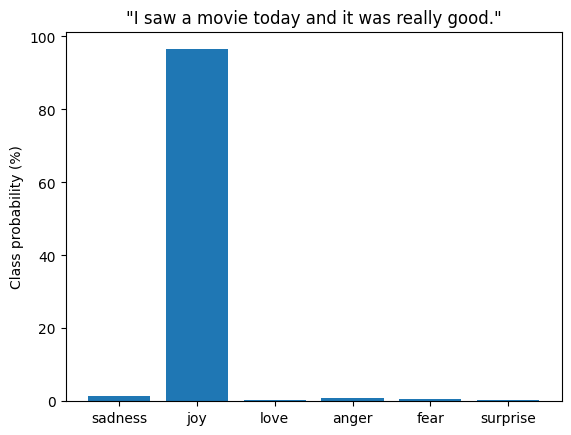

In [87]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()